## Demand Forecasting Introduction

Airline flight demand forecasting plays a pivotal role in the aviation industry, enabling informed decisions
that span various aspects of operations. From identifying strategic opportunities for route expansion to
anticipating airport traffic peaks and optimizing staffing levels, demand forecasting provides airlines with
valuable insights to navigate the dynamic landscape of air travel.
In this project, we focus on demand forecasting tailored for consumers seeking to book future flights. Our
model empowers passengers to make informed decisions by providing relevant statistics and graphs
related to their selected departure airport and date. Users can input their desired departure date and
airport, and the model will generate insights into historical and forecasted traffic patterns. This
information can guide passengers in determining appropriate arrival times, exploring alternative dates
with lower demand, or anticipating potential delays due to high traffic volumes.

## Demand Forecasting - Model Selection, Validation, and Evaluation

To effectively forecast demand, we employ a combination of data visualization and time series analysis
techniques. Initial data visualization utilizes Plotly to generate line plots, revealing trends in daily flight
counts over time. Boxplots further illuminate variations in flight counts based on the day of the week and
month, highlighting seasonal patterns.
Next, we delve into the core steps of time series analysis, including decomposition, stationarity checks,
and autocorrelation analysis. Decomposition separates the data into trend, seasonality, and residual
components, allowing for a deeper understanding of underlying patterns. The Augmented Dickey-Fuller
test assesses stationarity, with differencing applied when necessary to stabilize the data. Autocorrelation
and Partial Autocorrelation Function (ACF and PACF) plots guide the selection of autoregressive (AR)
and moving average (MA) components in the ARIMA model, effectively capturing temporal
dependencies.
We commence model selection and validation by employing traditional time series forecasting methods,
namely ARIMA and SARIMA. Two ARIMA models are evaluated: one based on parameters inferred
from ACF and PACF plots, and the other using parameters determined by auto_arima. SARIMA is also
evaluated to account for seasonality. The highest performing model among these three is then selected,
and additional exogenous variables such as day of week, holiday, and month are incorporated before
performing a final analysis of the results.
For comparison, we also develop an XGBOOST model using the same exogenous variables. To evaluate
model performance, residual analysis is conducted, assessing the normality of residuals. Forecasts are
generated and validated, and model accuracy is measured using Symmetric Mean Absolute Percentage
Error (SMAPE) and Mean Absolute Percentage Error (MAPE). The model with the best resulting
SMAPE and MAPE values is ultimately selected for our dashboard.

In [1]:
from sqlalchemy import create_engine, Column, Integer, String, DateTime, func, extract
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import pandas as pd
%matplotlib inline
import matplotlib, math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
import sys
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import datetime
from dateutil.relativedelta import *
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import log
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from sqlalchemy import create_engine, MetaData, Table, select, and_
import plotly.graph_objects as go
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
# Define the SQL Server connection parameters
server = 'airborneanalytics.cpdhuvhrm3nv.us-east-1.rds.amazonaws.com'
database = 'airborneanalytics'  
username = 'Hidden'
password = 'Hidden'

connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

engine = create_engine(connection_string)

In [3]:
# Create a line plot using Plotly
def plot_daily_flight_trend(df, columns, ap_code):
    fig = px.line(df, x=df.index, y=columns, title=f"Daily Inbound/Outbound Traffic at {ap_code}", template='seaborn')
    fig.update_xaxes(title_text='Flight Date')
    fig.update_yaxes(title_text='Flight Count')
    fig.update_layout(title_x=0.5)

    fig.show()

def create_box_plot(dataframe, x_column):
    fig = px.box(dataframe, x=x_column, y='Total_AirTraffic_count', title=f'Total Airport Traffic by {x_column}', template='seaborn')

    # Update axis labels
    fig.update_xaxes(title_text=x_column)
    fig.update_yaxes(title_text='Flight Count')

    # Center the title above the plot
    fig.update_layout(title_x=0.5)

    # Show the plot
    fig.show()    
    
def decompose_series(pd_series):
    #Decompose the series into monthly segments
    decomp = sm.tsa.seasonal_decompose(pd_series)
    
    fig = decomp.plot()
    fig.set_size_inches(10,10)
    
def test_stationarity(timeseries, window=12, cutoff=0.01):

    # Determining rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Create traces for Plotly
    trace_original = go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue'))
    trace_mean = go.Scatter(x=rolmean.index, y=rolmean, mode='lines', name='Rolling Mean', line=dict(color='red'))
    trace_std = go.Scatter(x=rolstd.index, y=rolstd, mode='lines', name='Rolling Std', line=dict(color='black'))

    # Create layout
    layout = go.Layout(
        title='Rolling Mean & Standard Deviation',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Value'),
        showlegend=True,
        title_x=0.5,  # Center the title
        title_y=0.9   # Adjust the y-coordinate as needed
    )

    # Create figure
    fig = go.Figure(data=[trace_original, trace_mean, trace_std], layout=layout)

    # Show the plot
    fig.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

def plot_residual_analysis(model):
    # Get residuals from the model and convert to NumPy array
    resid = np.array(model.resid)

    # Perform normality test
    normal_test_result = normaltest(resid)
    print(f"Normality Test: Chi-squared={normal_test_result.statistic}, p-value={normal_test_result.pvalue}")

    # Plot Residual Distribution
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot Residual Distribution
    sns.distplot(resid, fit=stats.norm, ax=ax0)
    (mu, sigma) = stats.norm.fit(resid)
    ax0.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    ax0.set_ylabel('Frequency')
    ax0.set_title('Residual Distribution')

    # Plot ACF
    sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()
    
def calculate_first_difference(df, column):
    """
    Calculate the first difference of a column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column: Name of the column for which to calculate the first difference

    Returns:
    - df_diff: DataFrame with the first difference column added
    """
    df_diff = df.copy()
    df_diff[column] = df[column] - df[column].shift(1)
    return df_diff
    
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    return mape, smape

def calculate_metrics(results_df, test_col='Test', pred_cols=None):
    if pred_cols is None:
        pred_cols = results_df.columns.difference([test_col])

    metrics_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE', 'R2'])

    for model_col in pred_cols:
        y_true = results_df[test_col]
        y_pred = results_df[model_col]

        # Drop rows with NaN values
        non_nan_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true = y_true[non_nan_mask]
        y_pred = y_pred[non_nan_mask]

        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(abs((y_true - y_pred) / y_true)) * 100
        smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))
        r2 = r2_score(y_true, y_pred)

        metrics_df[model_col] = [mae, mse, rmse, mape, smape, r2]

    return metrics_df

In [4]:


# Create a SQLAlchemy engine
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

engine = create_engine(connection_string)

# Create a connection
connection = engine.connect()

# Replace 'Airport_Traffic_2' and 'US_Holidays' with the actual table names
airport_traffic_table_name = 'Airport_Traffic_2'
holidays_table_name = 'US_Holidays'

# Create a connection
connection = engine.connect()

# Reflect the table structures
metadata = MetaData()
airport_traffic_table = Table(airport_traffic_table_name, metadata, autoload=True, autoload_with=engine)
holidays_table = Table(holidays_table_name, metadata, autoload=True, autoload_with=engine)

# Build a select query to return all columns from both tables with the join condition
select_query = select([airport_traffic_table, holidays_table]).select_from(
    airport_traffic_table.outerjoin(holidays_table, and_(
        airport_traffic_table.c.FlightDate == holidays_table.c.Date,
        airport_traffic_table.c.FlightDate <= '2019-12-31'

    ))
)

# Execute the query and fetch all rows into a Pandas DataFrame
daily_ap_cnt_df = pd.read_sql_query(select_query, connection)

# Close the connection
connection.close()

In [5]:
airport_selection = 'DTW'

In [6]:
# Ensure that the 'FlightDate' column is in datetime format
daily_ap_cnt_df['FlightDate'] = pd.to_datetime(daily_ap_cnt_df['FlightDate'])
daily_ap_cnt_df = daily_ap_cnt_df.drop(columns=['Date'])
daily_ap_cnt_df = daily_ap_cnt_df.set_index('FlightDate')
daily_ap_cnt_df = daily_ap_cnt_df.sort_values(by='FlightDate', ascending=True)

daily_ap_cnt_df['Month'] = daily_ap_cnt_df.index.month
#daily_ap_cnt_df['DayofMonth'] = daily_ap_cnt_df.index.day
daily_ap_cnt_df['DayOfWeek'] = daily_ap_cnt_df.index.dayofweek
daily_ap_cnt_df['weekofyear'] = daily_ap_cnt_df.index.isocalendar().week
daily_ap_cnt_df['holiday_bool'] = pd.notnull(daily_ap_cnt_df['Holiday']).astype(int)
#daily_ap_cnt_df = pd.get_dummies(daily_ap_cnt_df, columns = ['Month','Holiday','DayOfWeek','weekofyear'] , prefix = ['Month','Holiday','DayOfWeek','weekofyear'], dtype=int)
#daily_ap_cnt_df = daily_ap_cnt_df.astype(int)

daily_ap_cnt_df.head(5)

Airport  Origin_AirTraffic_count  Dest_AirTraffic_count  \
FlightDate                                                           
2018-01-01     LAX                      601                    599   
2018-01-01     RNO                       47                     46   
2018-01-01     BDL                       77                     75   
2018-01-01     ORF                       45                     45   
2018-01-01     ITO                       18                     19   

            Total_AirTraffic_count         Holiday  Month  DayOfWeek  \
FlightDate                                                             
2018-01-01                    1200  New Year's Day      1          0   
2018-01-01                      93  New Year's Day      1          0   
2018-01-01                     152  New Year's Day      1          0   
2018-01-01                      90  New Year's Day      1          0   
2018-01-01                      37  New Year's Day      1          0   

            weekofyear  holiday_bool  
FlightDate                            
2018-01-01           1             1  
2018-01-01           1             1  
2018-01-01           1             1  
2018-01-01           1             1  
2018-01-01           1             1

In [7]:
daily_ap_cnt_df_filtered = daily_ap_cnt_df[(daily_ap_cnt_df['Airport'] == airport_selection) & (daily_ap_cnt_df.index <= '2019-12-31')]

## Inbound/Outbound Demand Trends

In [8]:
columns_to_plot = ['Origin_AirTraffic_count', 'Dest_AirTraffic_count', 'Total_AirTraffic_count']
plot_daily_flight_trend(daily_ap_cnt_df_filtered, columns_to_plot, airport_selection)

## Demand by Day/Week/Month

In [9]:
create_box_plot(daily_ap_cnt_df_filtered, 'DayOfWeek')
#create_box_plot(daily_ap_cnt_df_filtered, 'DayofMonth')
create_box_plot(daily_ap_cnt_df_filtered, 'weekofyear')

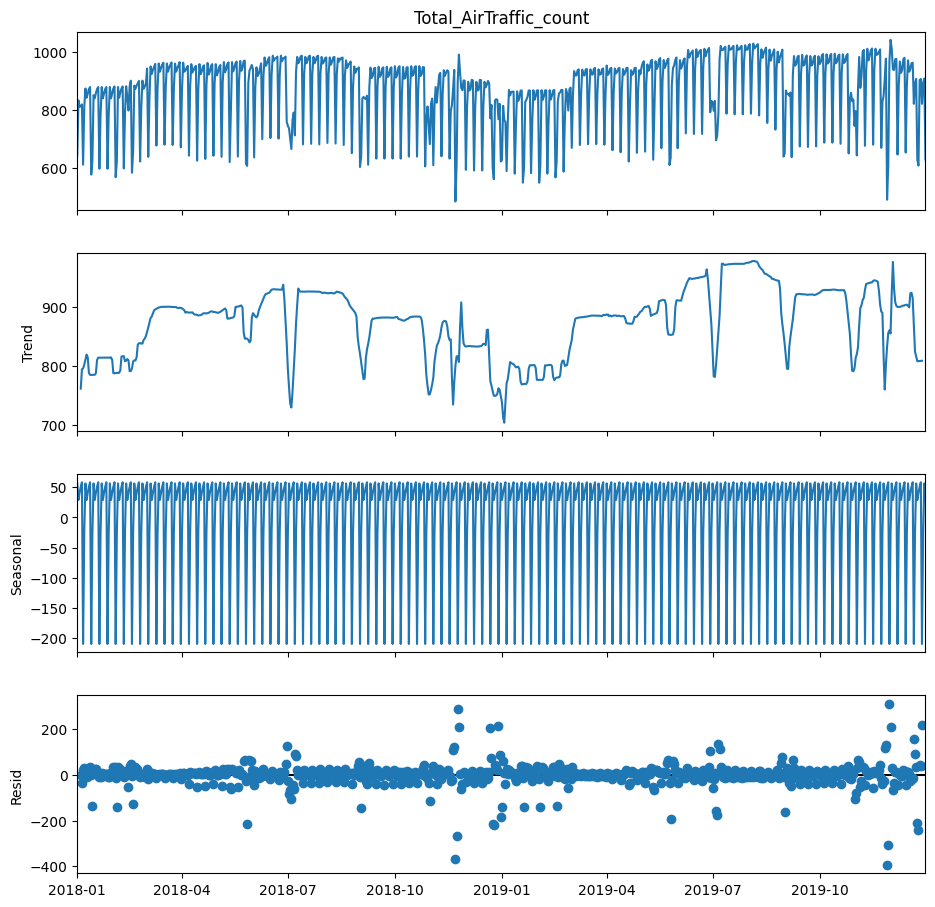

In [10]:
daily_ap_cnt_df_filtered = pd.get_dummies(daily_ap_cnt_df_filtered, columns = ['Month','Holiday','DayOfWeek','weekofyear'] , prefix = ['Month','Holiday','DayOfWeek','weekofyear'], dtype=int)
# Decomp and plot
decompose_series(daily_ap_cnt_df_filtered['Total_AirTraffic_count'])

In [11]:
test_stationarity(daily_ap_cnt_df_filtered['Total_AirTraffic_count'])

Results of Dickey-Fuller Test:
p-value = 0.0628. The series is likely non-stationary.


### Apply differencing to ensure Total_AirTraffic_count is stationary
The smaller p-value, the more likely it's stationary. Here our p-value is 0.06279. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.

In [12]:
first_diff_df = calculate_first_difference(daily_ap_cnt_df_filtered, 'Total_AirTraffic_count')
first_diff_series = first_diff_df['Total_AirTraffic_count'].dropna(inplace = False)
test_stationarity(first_diff_series, window = 12)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.


After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

## ACF and PACF

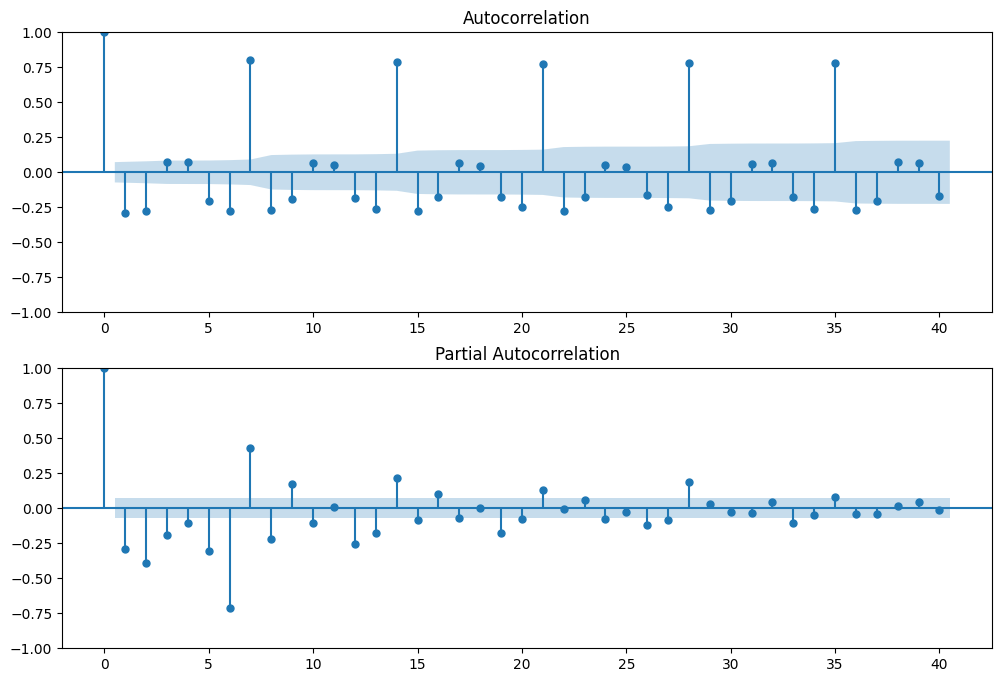

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff_series, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff_series, lags=40, ax=ax2)

# Modeling

## ARIMA (Autoregressive integrated moving average)

### Determine p, d, and q values based on ACF/PACF plots

Determining the parameters for an ARIMA model based on the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots involves analyzing the patterns in these plots to identify potential values for the orders p, d, and q. Here's a step-by-step guide:

ACF Plot (Autocorrelation Function):
The ACF plot shows the autocorrelation at different lags.

Identify the Autoregressive (AR) order (p):

Look for significant spikes at lags in the ACF plot.
The lag where the ACF drops off sharply after a spike is a potential candidate for the AR order.
Example:

If there is a significant spike at lag 1 and the ACF drops off sharply afterward, it suggests an AR order of 1.
PACF Plot (Partial Autocorrelation Function):
The PACF plot shows the partial autocorrelation at different lags, indicating the direct relationship between observations.

Identify the Moving Average (MA) order (q):

Look for significant spikes at lags in the PACF plot.
The lag where the PACF drops off sharply after a spike is a potential candidate for the MA order.
Example:

If there is a significant spike at lag 1 in the PACF plot and it drops off sharply afterward, it suggests an MA order of 1.
Differencing Order (d):
The differencing order (d) is determined based on the number of times differencing is required to achieve stationarity.

Check for Stationarity:

If the ACF and PACF plots show a gradual decay and no clear pattern, differencing may not be needed.
If there is a trend or seasonality in the ACF or PACF plots, consider differencing until the series becomes stationary.
Example:

If the original series has a trend, consider differencing once (d=1).
Putting It Together:
Based on the identified p, d, and q values, construct the ARIMA(p, d, q) model.
Fit the model to the time series data and perform diagnostic checks on the residuals to ensure that the model adequately captures the patterns.
Keep in mind that the process might involve some trial and error, and domain knowledge can be valuable in interpreting the results. Additionally, it's often useful to consider multiple plausible models and select the one that best fits the data based on criteria such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion).

In [14]:
arima_mod = sm.tsa.ARIMA(first_diff_series, order=(7, 1, 1)).fit()
print(arima_mod.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total_AirTraffic_count   No. Observations:                  729
Model:                     ARIMA(7, 1, 1)   Log Likelihood               -4164.159
Date:                    Mon, 27 Nov 2023   AIC                           8346.318
Time:                            13:46:28   BIC                           8387.631
Sample:                        01-02-2018   HQIC                          8362.259
                             - 12-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4612      0.026    -17.501      0.000      -0.513      -0.410
ar.L2         -0.5018      0.029    -17.493      0.000      -0.558      -0.446
ar.L3         -0.422

### Model Fit and Evaluation:
Log Likelihood:

The log-likelihood is a measure of how well the model explains the observed data. Higher values indicate better fit.
AIC (Akaike Information Criterion):

AIC is an information criterion that balances goodness of fit and model complexity. Lower values are generally preferred.
BIC (Bayesian Information Criterion):

BIC is another information criterion that penalizes model complexity. Like AIC, lower values are preferred.
Sample:

The time range of the dataset is from January 2, 2018, to December 31, 2019.
### Coefficients:
AR (Autoregressive) Coefficients (ar.L1, ar.L2, ..., ar.L7):

These coefficients represent the weights applied to the past observations in the autoregressive component of the model.
MA (Moving Average) Coefficient (ma.L1):

This coefficient represents the weight applied to the past forecast errors in the moving average component of the model.
sigma2:

The estimated variance of the residuals.
### Statistical Tests:
Ljung-Box (L1) (Q):

A statistical test for the presence of autocorrelation in the residuals. A significant p-value suggests the presence of autocorrelation.
Jarque-Bera (JB):

A statistical test for normality of the residuals. A significant p-value suggests non-normality.
### Diagnostic Measures:
Heteroskedasticity (H):

A measure of whether the variance of the residuals is constant. A value significantly different from 1 indicates heteroskedasticity.
Skew:

A measure of the skewness of the residuals. A value close to 0 suggests symmetry.
Kurtosis:

A measure of the kurtosis (tailedness) of the residuals. Higher values indicate heavier tails.
### Interpretation:
The ARIMA model has been specified with 7 autoregressive terms (lags) and 1 moving average term. The differencing order is 1.
The coefficients indicate the impact of past observations on the current observation.
The Ljung-Box test and Jarque-Bera test provide diagnostic checks on the residuals.
The values for AIC and BIC help evaluate the trade-off between model fit and complexity.
The estimated variance of the residuals (sigma2) is provided.

## Analyze the result
To see how our first model perform, we can plot the residual distribution. Our very low Pvalue suggests that the residuals do not follow a normal distribution. Deviations from normality may indicate that the model is missing some important features or that the underlying data has non-Gaussian characteristics.

ACF and PACF plots help assess whether there is any autocorrelation or remaining structure in the residuals. If significant autocorrelation is present at certain lags, it may indicate that the model has not captured all the temporal patterns.

Normality Test: Chi-squared=191.56128279555634, p-value=2.5292745132756454e-42


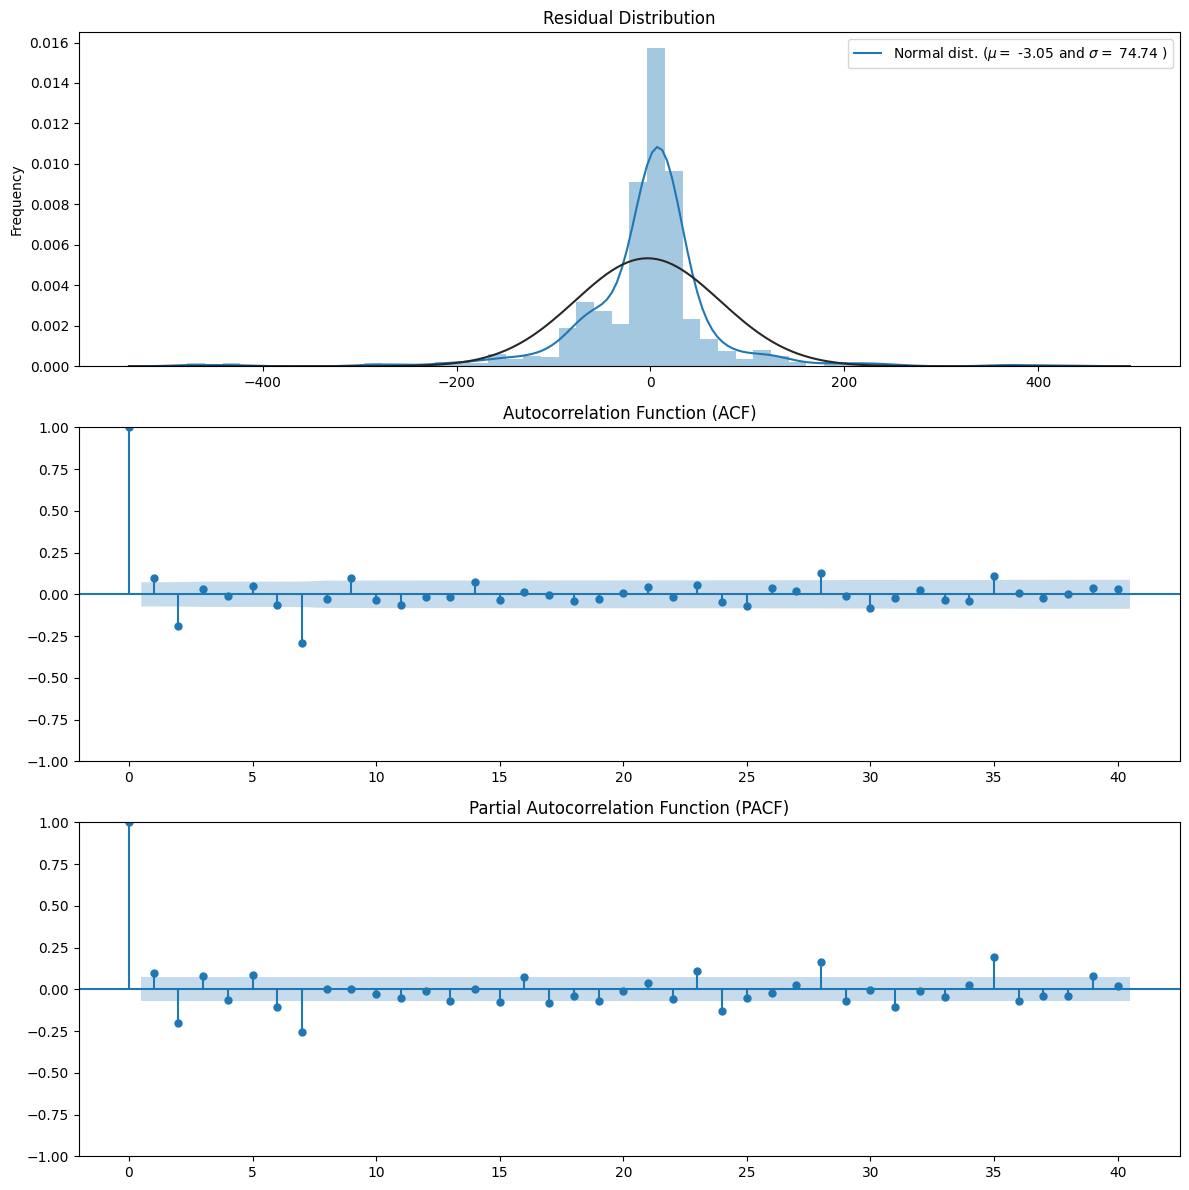

In [15]:
plot_residual_analysis(arima_mod)

## Auto ARIMA

Since our residuals do not follow a normal distribution, we will attempt to use Auto ARIMA to find the optimal p, d, and q values

In [16]:
# Use auto_arima to find the optimal ARIMA parameters
auto_arima_model = auto_arima(first_diff_series, seasonal=True, suppress_warnings=True, stepwise=True)

# Extract the optimal order
order = auto_arima_model.order

# Fit the ARIMA model with the optimal order
arima_model_auto = sm.tsa.ARIMA(first_diff_series, order=order).fit()

print(arima_model_auto.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total_AirTraffic_count   No. Observations:                  729
Model:                     ARIMA(5, 0, 3)   Log Likelihood               -4327.408
Date:                    Mon, 27 Nov 2023   AIC                           8674.816
Time:                            13:46:56   BIC                           8720.733
Sample:                        01-02-2018   HQIC                          8692.532
                             - 12-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0500      0.073      0.684      0.494      -0.093       0.193
ar.L1         -1.0616      0.061    -17.494      0.000      -1.180      -0.943
ar.L2         -0.237

Normality Test: Chi-squared=76.99353428467153, p-value=1.910145540868327e-17


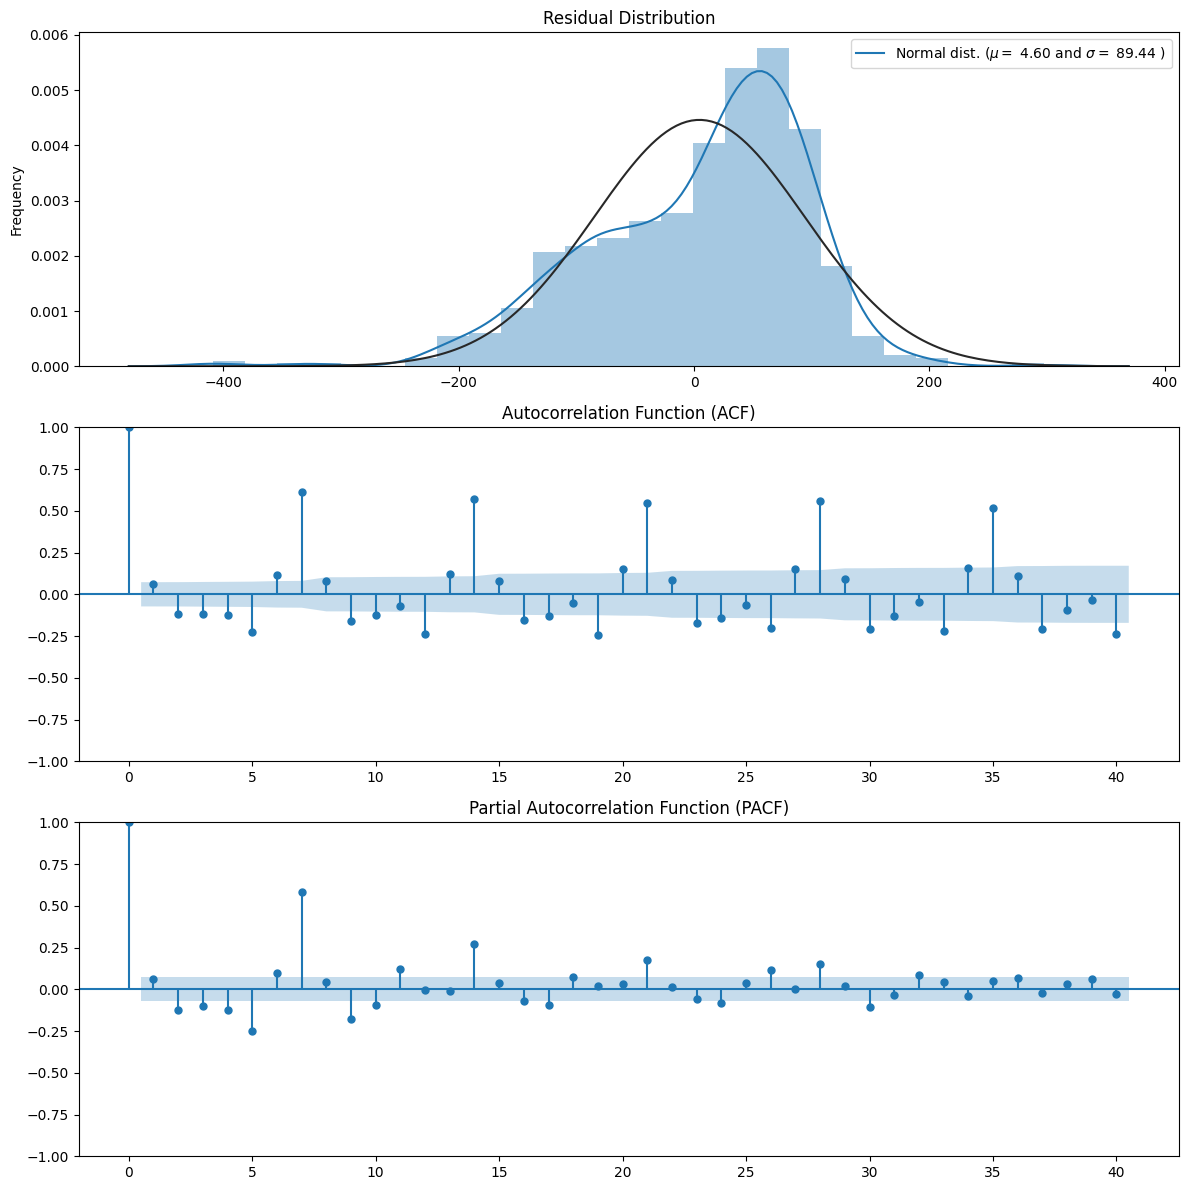

In [17]:
plot_residual_analysis(arima_model_auto)

## Consider seasonality affect by SARIMA

In [18]:
sarima_mod = sm.tsa.statespace.SARIMAX(first_diff_series,order=(5, 0, 3),seasonal_order=(5, 0, 3,12),
                                       enforce_invertibility=False,enforce_stationarity=False, trend='n')
sarima_results = sarima_mod.fit()
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:             Total_AirTraffic_count   No. Observations:                  729
Model:             SARIMAX(5, 0, 3)x(5, 0, 3, 12)   Log Likelihood               -3893.524
Date:                            Mon, 27 Nov 2023   AIC                           7821.048
Time:                                    13:50:00   BIC                           7897.519
Sample:                                01-02-2018   HQIC                          7850.681
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1696      0.667      0.254      0.799      -1.138       1.477
ar.L2         -0.7622      0.586   

Normality Test: Chi-squared=95.49845315427939, p-value=1.8313627754220752e-21


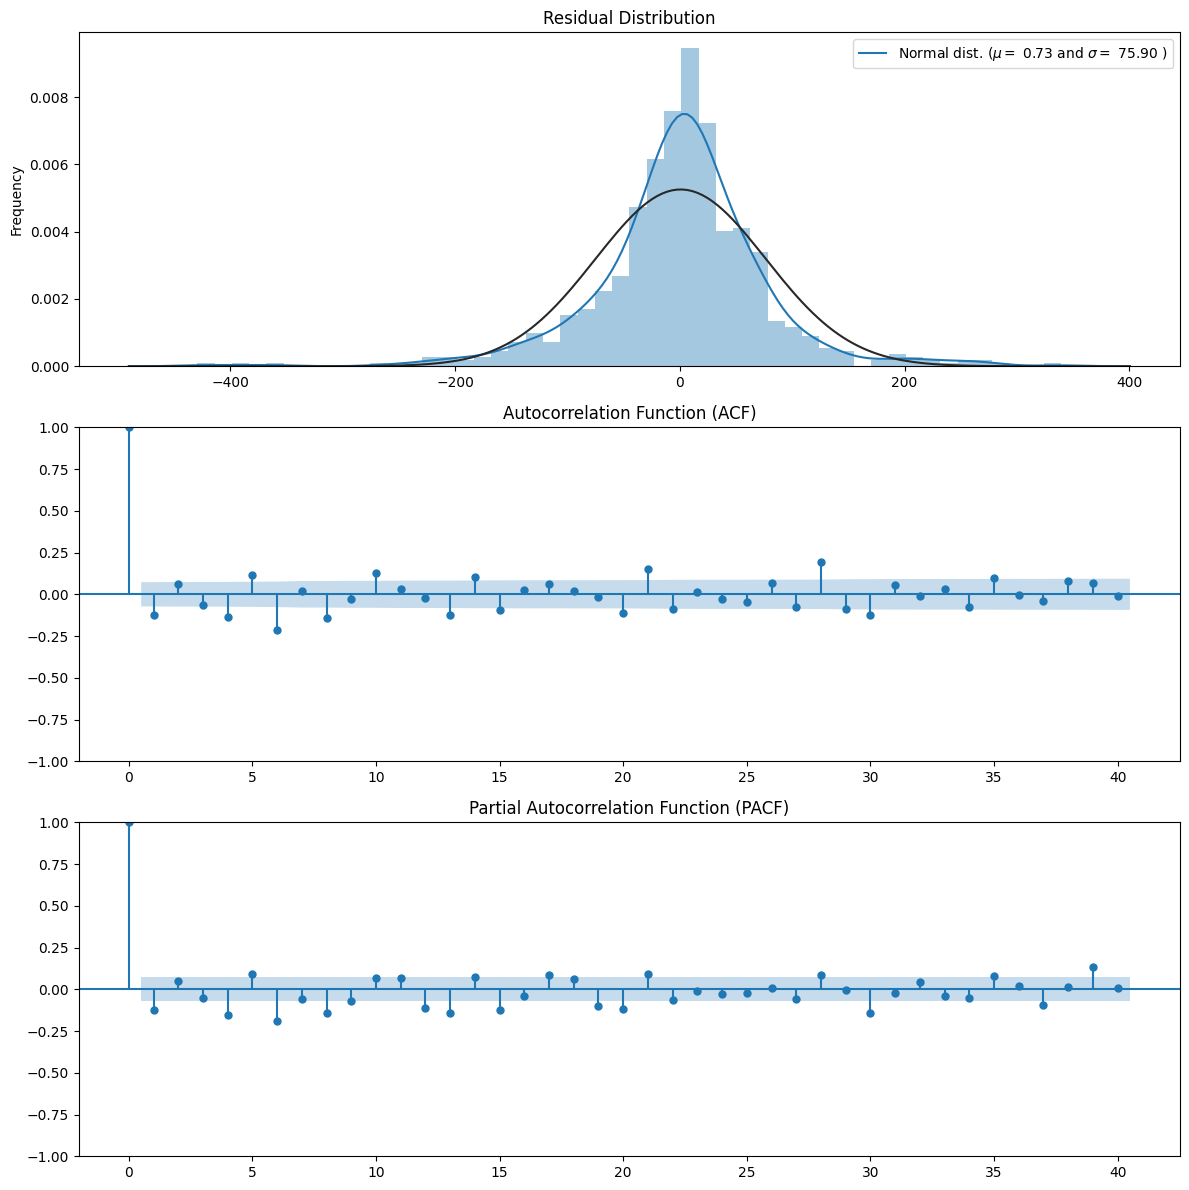

In [19]:
plot_residual_analysis(sarima_results)

## Time series prediction and results analysis

In [20]:
daily_ap_cnt_df_split = daily_ap_cnt_df_filtered#[['Total_AirTraffic_count']]

train_orig = daily_ap_cnt_df_split[daily_ap_cnt_df_split.index < pd.to_datetime("2019-11-01", format='%Y-%m-%d')]
test_orig = daily_ap_cnt_df_split[daily_ap_cnt_df_split.index >= pd.to_datetime("2019-11-01", format='%Y-%m-%d')]
#y = train['Total_AirTraffic_count']

In [21]:
# Split the differenced series into training and test sets
train_diff = first_diff_df[first_diff_df.index < pd.to_datetime("2019-11-01")].dropna(inplace = False)
test_diff = first_diff_df[first_diff_df.index >= pd.to_datetime("2019-11-01")].dropna(inplace = False)

In [22]:
def forecast_and_create_df(train, test, is_original_series=True):
    """
    Forecast using ARIMA, Auto ARIMA, and SARIMA models and return a DataFrame with predictions.

    Parameters:
    - train: Training time series
    - test: Test time series
    - is_original_series: Flag indicating if the series is original (True) or differenced (False)

    Returns:
    - results_df: DataFrame with predictions
    """

    # Combine train and test for simplicity
    combined_series = pd.concat([train['Total_AirTraffic_count'], test['Total_AirTraffic_count']])

    # Initialize results_df with the combined series
    results_df = pd.DataFrame(combined_series, columns=['Total_AirTraffic_count'])
    exog_train = train.drop(columns=['Airport','Origin_AirTraffic_count','Dest_AirTraffic_count','Total_AirTraffic_count'])
    exog_test = test.drop(columns=['Airport','Origin_AirTraffic_count','Dest_AirTraffic_count','Total_AirTraffic_count'])
    
    # Fit the SARIMAX(5, 0, 3) model with exogenous variables
    sarimax_exog = SARIMAX(
        endog=train['Total_AirTraffic_count'],
        exog=exog_train,
        order=(5, 0, 3),
        enforce_invertibility=False,
        enforce_stationarity=False,
        trend='n'
    ).fit()

    # Fit ARIMA(7, 1, 1) model on the training data
    arima_711 = ARIMA(train['Total_AirTraffic_count'], order=(7, 1, 1)).fit()

    # Fit Auto ARIMA(5, 0, 3) model on the training data
    auto_arima_503 = pm.auto_arima(train['Total_AirTraffic_count'], seasonal=True, m=12, stepwise=True, suppress_warnings=True)

    # Fit SARIMA(5, 0, 3)(5, 0, 3, 12) model on the training data
    sarima_503_12 = sm.tsa.statespace.SARIMAX(train['Total_AirTraffic_count'], order=(5, 0, 3), seasonal_order=(5, 0, 3, 12),
                                             enforce_invertibility=False, enforce_stationarity=False, trend='n').fit()

    # Make predictions for the forecast period
    y_pred_arima = arima_711.get_forecast(steps=len(test['Total_AirTraffic_count'])).predicted_mean.round().astype(int)
    y_pred_auto_arima = np.round(auto_arima_503.predict(n_periods=len(test['Total_AirTraffic_count']))).astype(int)
    y_pred_sarima = sarima_503_12.get_forecast(steps=len(test['Total_AirTraffic_count'])).predicted_mean.round().astype(int)
    y_pred_sarimax_exog = sarimax_exog.get_forecast(steps=len(test['Total_AirTraffic_count']), exog=exog_test).predicted_mean


    # Convert differenced predictions back to the original scale
    if not is_original_series:
        y_pred_arima = np.cumsum(y_pred_arima) + test['Total_AirTraffic_count'].iloc[-1]
        y_pred_auto_arima = np.cumsum(y_pred_auto_arima) + test['Total_AirTraffic_count'].iloc[-1]
        y_pred_sarima = np.cumsum(y_pred_sarima) + test['Total_AirTraffic_count'].iloc[-1]
        y_pred_sarimax_exog = np.cumsum(y_pred_sarimax_exog) + test['Total_AirTraffic_count'].iloc[-1]

    # Update results_df with predictions
    results_df['ARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'ARIMA_Predictions'] = y_pred_arima

    results_df['Auto_ARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'Auto_ARIMA_Predictions'] = y_pred_auto_arima

    results_df['SARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'SARIMA_Predictions'] = y_pred_sarima
    
    results_df['SARIMAX_exog_Predictions'] = np.nan
    results_df.loc[test_orig.index, 'SARIMAX_exog_Predictions'] = y_pred_sarimax_exog
    
    # Plot the original time series, test set, and predictions
    fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=False)

    # Plot 1: Original Time Series, Test Set, and Predictions
    ax[0].plot(results_df.index, results_df['Total_AirTraffic_count'], color='black', label='Original Series', linewidth=3)
    ax[0].plot(test.index, test['Total_AirTraffic_count'], color='red', label='Test Set Original')
    ax[0].plot(results_df.index, results_df['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
    ax[0].plot(results_df.index, results_df['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
    ax[0].plot(results_df.index, results_df['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
    ax[0].plot(results_df.index, results_df['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Predictions')
    
    ax[0].set_ylabel('Number of Flights')
    ax[0].set_title("Model Comparisons")
    ax[0].legend()

    # Plot 2: Predicted Time Frame Only (Zoomed In)
    ax[1].plot(test.index, test['Total_AirTraffic_count'], color='red', label='Test Set Original', linewidth=3)
    ax[1].plot(results_df.index, results_df['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
    ax[1].plot(results_df.index, results_df['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
    ax[1].plot(results_df.index, results_df['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
    ax[1].plot(results_df.index, results_df['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Exog Predictions')
                                            
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Number of Flights')
    ax[1].set_title("Predicted Time Frame")
    ax[1].legend()

    # Set x-axis limits for the second subplot
    ax[1].set_xlim(test.index.min(), test.index.max())

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results_df


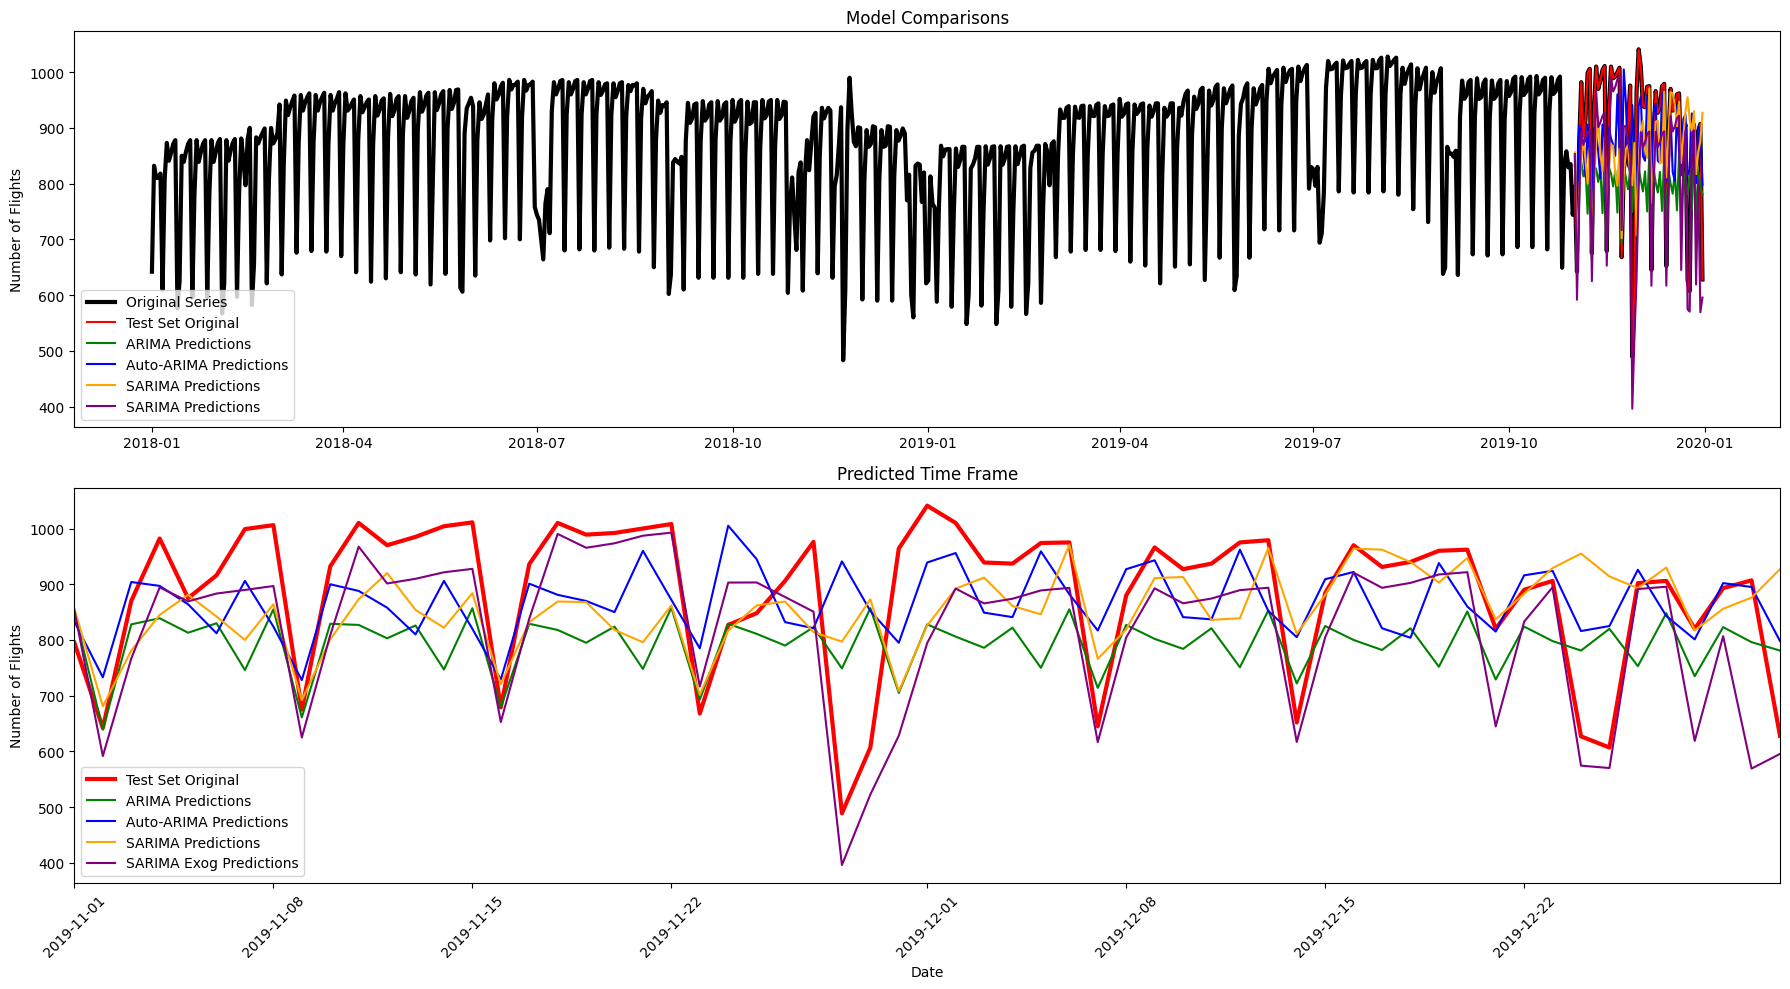

In [23]:
results_orig = forecast_and_create_df(train_orig, test_orig, is_original_series=True)

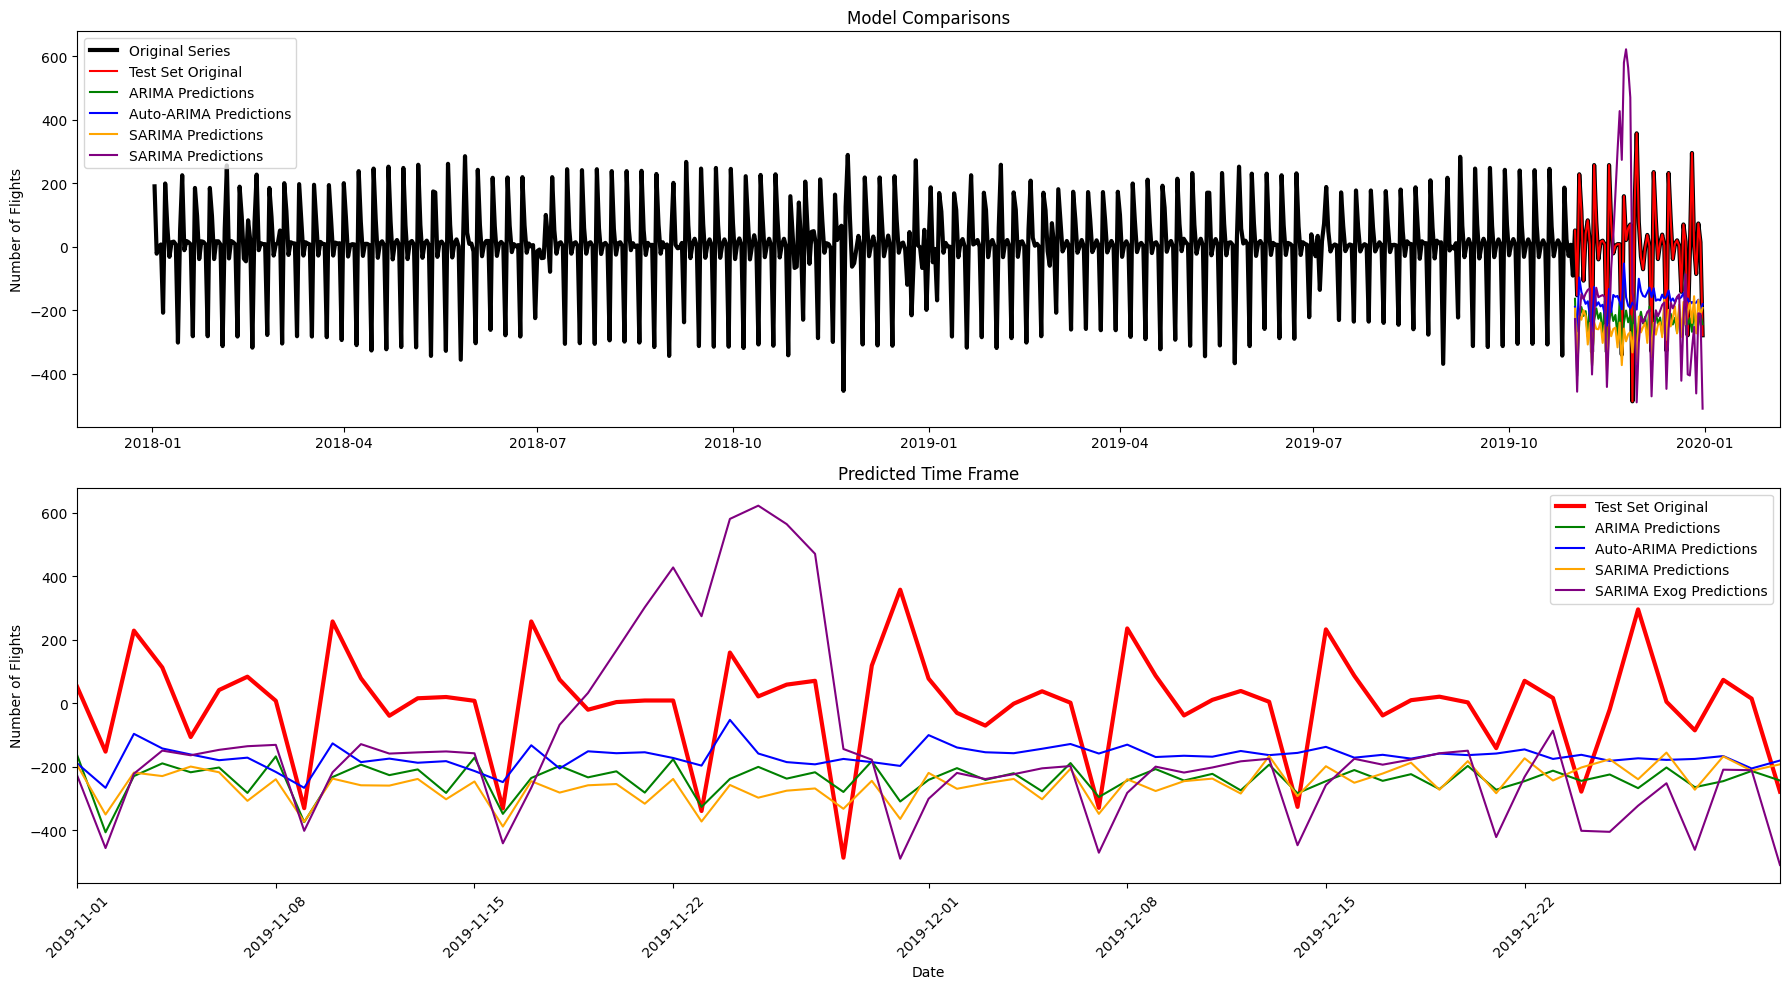

In [24]:
results_diff = forecast_and_create_df(train_diff, test_diff, is_original_series=False)

In [25]:
model_results_comparison_orig = calculate_metrics(results_orig, test_col='Total_AirTraffic_count', pred_cols=None)
model_results_comparison_orig

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAE           132.213115               97.147541                 75.660379   
MSE         22383.590164            15121.245902              10011.703953   
RMSE          149.611464              122.968475                100.058503   
MAPE           15.092455               12.187771                  8.603332   
SMAPE          15.680816               11.583008                  9.268125   
R2             -0.273305                0.139818                  0.430478   

       SARIMA_Predictions  
MAE             97.819672  
MSE          17397.721311  
RMSE           131.900422  
MAPE            12.090067  
SMAPE           11.643461  
R2               0.010319

In [26]:
model_results_comparison_diff = calculate_metrics(results_diff, test_col='Total_AirTraffic_count', pred_cols=None)
model_results_comparison_diff

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAE           249.852459              205.114754                276.690020   
MSE         79546.770492            51637.770492             101824.376808   
RMSE          282.040370              227.239456                319.099321   
MAPE         1571.515123             1231.282701               1551.485451   
SMAPE         161.776111              162.105405                165.766863   
R2             -1.951202               -0.915772                 -2.777706   

       SARIMA_Predictions  
MAE            263.885246  
MSE          87279.360656  
RMSE           295.430805  
MAPE          1671.828560  
SMAPE          162.274609  
R2              -2.238083

## XGBOOST

In [27]:
features = [ 'holiday_bool',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Holiday_4th of July', 'Holiday_Christmas Day','Holiday_Christmas Eve','Holiday_Columbus Day',
        'Holiday_Eastern Easter','Holiday_Juneteenth', 'Holiday_Labor Day','Holiday_Labor Day Weekend', 
        'Holiday_Martin Luther King, Jr. Day','Holiday_Memorial Day',"Holiday_New Year's Day","Holiday_New Year's Eve",
        'Holiday_Thanksgiving Day','Holiday_Thanksgiving Eve',"Holiday_Valentine's Day",'Holiday_Veterans Day',
         "Holiday_Washington's Birthday",'Holiday_Western Easter', 'DayOfWeek_0',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'weekofyear_1', 'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5', 'weekofyear_6',
        'weekofyear_7', 'weekofyear_8', 'weekofyear_9', 'weekofyear_10', 'weekofyear_11', 'weekofyear_12',
        'weekofyear_13', 'weekofyear_14', 'weekofyear_15', 'weekofyear_16', 'weekofyear_17', 'weekofyear_18',
        'weekofyear_19', 'weekofyear_20', 'weekofyear_21', 'weekofyear_22', 'weekofyear_23', 'weekofyear_24',
        'weekofyear_25', 'weekofyear_26', 'weekofyear_27', 'weekofyear_28', 'weekofyear_29', 'weekofyear_30',
        'weekofyear_31', 'weekofyear_32', 'weekofyear_33', 'weekofyear_34', 'weekofyear_35', 'weekofyear_36',
        'weekofyear_37', 'weekofyear_38', 'weekofyear_39', 'weekofyear_40', 'weekofyear_41', 'weekofyear_42',
        'weekofyear_43', 'weekofyear_44', 'weekofyear_45', 'weekofyear_46', 'weekofyear_47', 'weekofyear_48',
        'weekofyear_49', 'weekofyear_50', 'weekofyear_51', 'weekofyear_52']

In [28]:
X_train = train_orig[features]
y_train = train_orig['Total_AirTraffic_count']

X_test = test_orig[features]
y_test = test_orig['Total_AirTraffic_count']

In [29]:
# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                        n_estimators=1000,
#                        early_stopping_rounds=50,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         verbose=100)

In [46]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [1000, 1250, 1500, 1750, 2000],
    'subsample': [0.8, 0.9, 1.0],
}

# Create an XGBoost regressor
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', objective='reg:linear')

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_reg = grid_search.best_estimator_

# Fit the best model on the entire training set
best_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

ValueError: 'MAPE' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

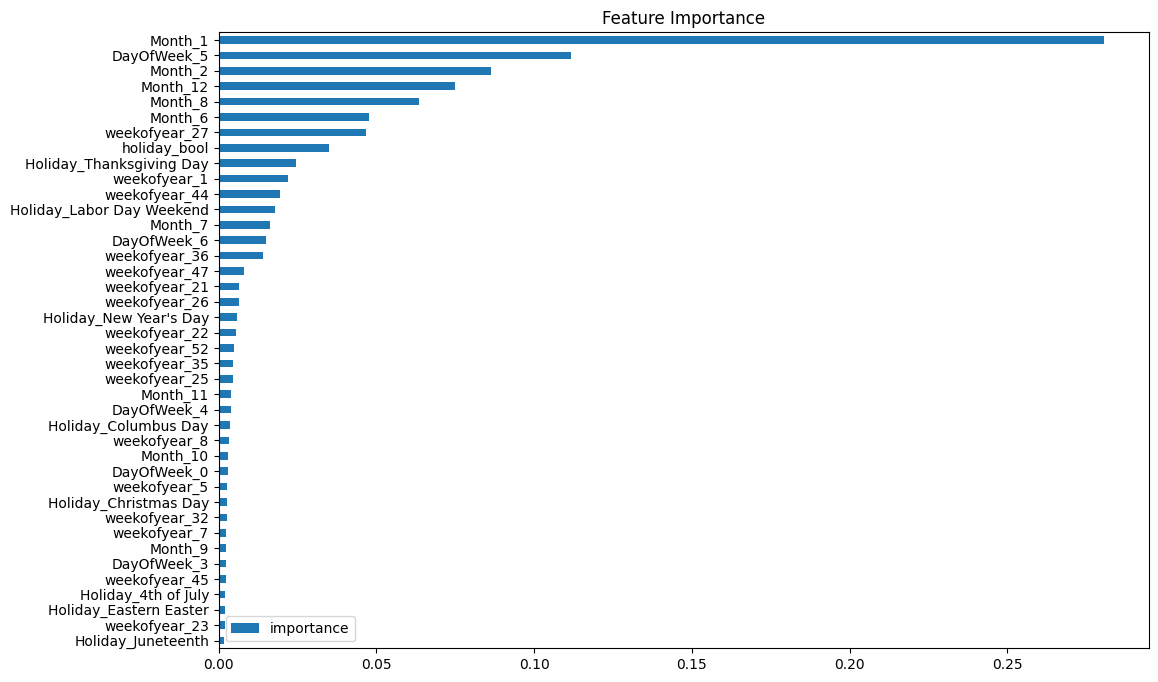

In [48]:
fi = pd.DataFrame(data=best_reg.feature_importances_,
             index=best_reg.feature_names_in_,
             columns=['importance'])

# Sort the DataFrame by importance and select the top 10
top_features = fi.sort_values('importance', ascending=False).head(40)

# Reverse the order to have the most important feature at the top
top_features = top_features[::-1]

# Increase plot size
fig, ax = plt.subplots(figsize=(12, 8))

top_features.plot(kind='barh', title='Feature Importance', ax=ax)
plt.show()

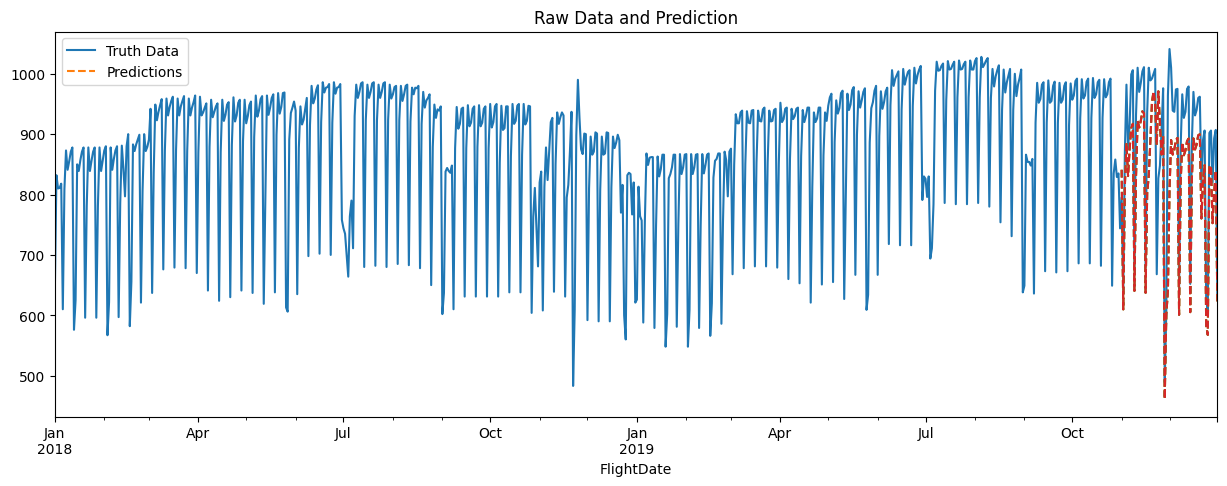

In [45]:
test_orig['XGBoost_Predictions'] = best_reg.predict(X_test)
results_orig = results_orig.merge(test_orig[['XGBoost_Predictions']], how='left', left_index=True, right_index=True)
ax = results_orig[['Total_AirTraffic_count']].plot(figsize=(15, 5))
results_orig['XGBoost_Predictions_x'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [42]:
#model_results_comparison_orig = calculate_metrics(results_orig, test_col='Total_AirTraffic_count', pred_cols=None)
filtered_results = model_results_comparison_orig.loc[['MAPE', 'SMAPE']]
filtered_results = filtered_results.drop(columns=['XGBoost_Predictions_x','XGBoost_Predictions_y'])
filtered_results

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAPE           15.092455               12.187771                  8.603332   
SMAPE          15.680816               11.583008                  9.268125   

       SARIMA_Predictions  XGBoost_Predictions  
MAPE            12.090067             8.453978  
SMAPE           11.643461             8.787503